# Subset Selection of A Toy Biased Dataset

In this tutorial, we will use a biased dataset which is manually curated. For the sake of
simplicity, we will only use `MaxMin` as the subset selection algorithm.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from io import BytesIO

# import cairosvg
from IPython.display import SVG

# import rdkit
# from PIL import Image
from selector.methods import (
    MaxMin,
    MaxSum,
    OptiSim,
    DISE,
    GridPartition,
    NSimilarity,
)
from selector.measures.similarity import pairwise_similarity_bit

In [2]:
def graph_mols(mols, molsPerRow=6, subImgSize=(200, 200), selected_ids=None, output_file=None):
    """Function to draw molecules from an SDF file."""
    IPythonConsole.drawOptions.legendFontSize = 14
    IPythonConsole.drawOptions.minFontSize = 14

    # selected mols
    if selected_ids is None:
        mols = np.array(mols)
    else:
        mols = np.array(mols)[selected_ids]

    label_list = [mol.GetProp("_Name").split(".")[0] for mol in mols]

    # img = Draw.MolsToGridImage(mols, legends=label_list, molsPerRow=5,
    #                            subImgSize=(250, 250), useSVG=False, returnPNG=True)

    # convert to 2D for drawing
    # smiles = [Chem.MolToSmiles(mol) for mol in mols]
    # mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    img = Draw.MolsToGridImage(
        mols,
        legends=label_list,
        molsPerRow=molsPerRow,
        subImgSize=subImgSize,
        maxMols=999999,
    )
    png = img.data

    # https://gist.github.com/greglandrum/56a80e84676fc3a24250b821d0faac13
    with open(output_file, "wb+") as f:
        f.write(png)

    # or
    # img
    # right click to save
    img = Draw.MolsToGridImage(
        mols,
        legends=label_list,
        molsPerRow=molsPerRow,
        subImgSize=subImgSize,
        useSVG=True,
        maxMols=999999,
    )


    return img

In [3]:
def rdkit_frag_desc(mols, return_df=False):
    """Generation of the RDKit fragment features.

    Parameters
    ----------
    mols: list
        A list of RDKit molecules.

    Returns
    -------
    df_features: PandasDataFrame
        A `pandas.DataFrame` object with compute Mordred descriptors.

    """
    # http://rdkit.org/docs/source/rdkit.Chem.Fragments.html
    # this implementation is taken from https://github.com/Ryan-Rhys/FlowMO/blob/
    # e221d989914f906501e1ad19cd3629d88eac1785/property_prediction/data_utils.py#L111
    fragments = {d[0]: d[1] for d in Descriptors.descList[115:]}
    frag_features = np.zeros((len(mols), len(fragments)))
    for idx, mol in enumerate(mols):
        features = [fragments[d](mol) for d in fragments]
        frag_features[idx, :] = features

    if return_df:
        feature_names = [desc[0] for desc in Descriptors.descList[115:]]
        df_features = pd.DataFrame(data=frag_features, columns=feature_names)
        return df_features
    else:
        return frag_features

In [4]:
# try new dataset

# import DataStructs module from rdkit
from rdkit import DataStructs

# 440 alkanes, 50 alcohols, 40 aldehydes, 9 ketones, 8 benzene containing and 3 ring containing molecules
# df = pd.read_csv("molecules_smiles_table_v3.csv")
df = pd.read_csv("molecules_smiles_table_v4.csv", sep=",")

# # # shuffle the dataset
# df = df.sample(frac=1, random_state=43)
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

df["SMILES"] = df["SMILES"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=True))

# cound the number of molecules in each class

print(f"total number of molecules: {len(df)}")
print(f"number of unique molecules: {len(df['SMILES'].unique())}")

# drop duplicates based on SMILES
df = df.drop_duplicates(subset="SMILES")

print(f"total number of molecules after removing duplicates: {len(df)}")
df["Category"].value_counts()


total number of molecules: 145
number of unique molecules: 145
total number of molecules after removing duplicates: 145


Category
alkane                98
alcohol               19
aldehyde              10
ketone                 9
benzene derivative     7
cycloalkane            2
Name: count, dtype: int64

/var/folders/wh/r1pfy4_x7997_9ngmj861fkr0000gn/T/ipykernel_78097/3544327890.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


<Figure size 600x400 with 0 Axes>

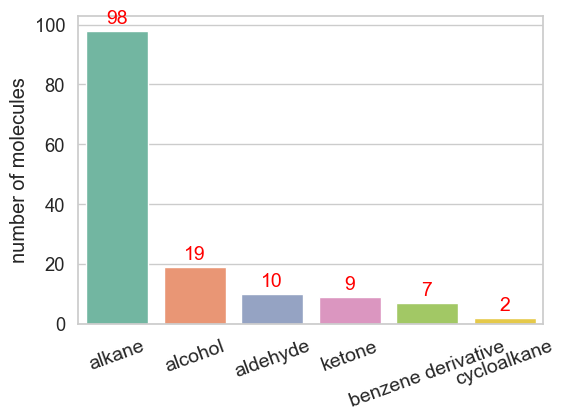

In [5]:
# plot the number of molecules in each class with matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

# set the figure size
plt.figure(figsize=(6, 4))
# # plot the pie chart
# df["Category"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90)


# plot the bar plot
sns.set(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("notebook", font_scale=1.2)
# set the figure size
plt.figure(figsize=(6, 4))
# plot the bar plot
sns.countplot(
    data=df,
    x="Category",
    order=df["Category"].value_counts().index,
    palette="Set2",
    # edgecolor="black",
)

# set the title and labels
# plt.title("Distribution of molecules in each class")
plt.xlabel("")
plt.ylabel("number of molecules")
# set the x ticks
plt.xticks(rotation=20)
plt.xticks(fontsize=14)
# add number of molecules on top center of each bar
counts = df["Category"].value_counts().values
for i, count in enumerate(counts):
    plt.text(
        i,
        count + 0.01 * max(counts),  # slight offset above the bar
        str(count),
        ha="center",
        va="bottom",
        fontsize=14,
        color="red",
    )
plt.savefig("molecules_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# generate RDKit molecules from SMILES
# PandasTools.AddMoleculeColumnToFrame(df, smilesCol="SMILES")
# mols = df["ROMol"].tolist()
mols = []
for idx, row in df.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    mol.SetProp("_Name", row["Category"])
    mols.append(mol)

# generate fragment features
# frag_features = rdkit_frag_desc(mols)

# fpgen = AllChem.GetMorganGenerator(radius=2)

ecfp = []
for mol in mols:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=528)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    ecfp.append(arr)

ecfp = np.array(ecfp)

# compute the modified Tanimoto similarity
ecfp_sim = pairwise_similarity_bit(ecfp, "modified_tanimoto")
ecfp_dist = 1 - ecfp_sim

[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerator
[20:40:24] DEPRECATION WARNING: please use MorganGenerat

[10, 22, 21, 19, 79, 106, 136, 103, 51]


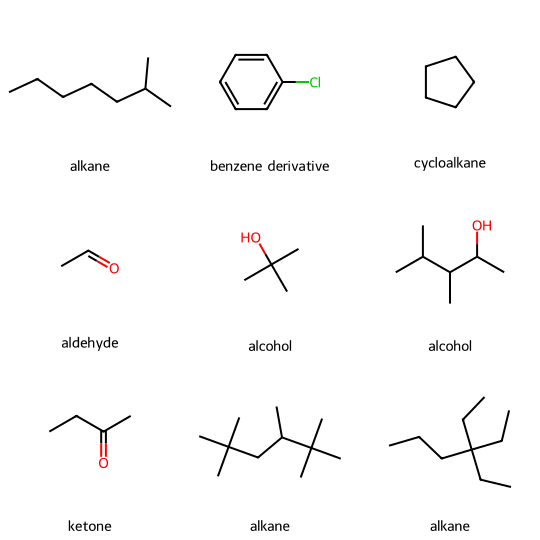

In [7]:
# subset selection with MaxMin
selected_ids8 = MaxMin(fun_dist=None, ref_index=None).select(x=ecfp_dist, size=9)
print(selected_ids8)

graph_mols(mols, molsPerRow=3, subImgSize=(180, 180), selected_ids=selected_ids8, output_file="selected_mols_maxmin.png")

In [8]:
# print out the SMILES for selected molecules
for idx in selected_ids8:
    print(df.loc[idx, "SMILES"])

CCCCCC(C)C
Clc1ccccc1
C1CCCC1
CC=O
CC(C)(C)O
CC(C)C(C)C(C)O
CCC(C)=O
CC(CC(C)(C)C)C(C)(C)C
CCCC(CC)(CC)CC


/opt/homebrew/Caskroom/miniforge/base/envs/selector_py312/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/selector_py312/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


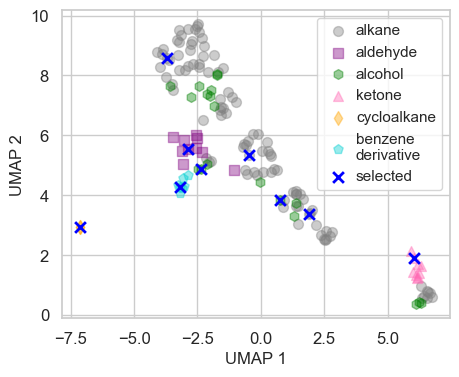

In [9]:
# umap visualization of the molecules
from umap import UMAP

umap = UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=15,
    # min_dist=0.1,
    # min_dist=0.2,
    min_dist=0.12,
    metric="jaccard",
)
X_umap = umap.fit_transform(ecfp)
df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])

# plot the UMAP projections
# fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = plt.subplots(figsize=(5, 4))
categories = df["Category"].unique()
colors_list = [
    "grey",
    "green",
    "hotpink",
    "purple",
    "orange",
    # "blue",
    # "cyan",
    # "orangered",
    "darkturquoise",
]
# markers_list = ["^", "x", "*", "_", "|", "2", "p", ">", "<", "v", "s"]
markers_list = ["o", "h", "^", "s", "d", "p"]
colors = dict(zip(categories, colors_list))
markers = dict(zip(categories, markers_list))

# df["Category"].unique()
for category in ['alkane', 'aldehyde', 'alcohol', 'ketone', 'cycloalkane', 'benzene derivative']:
    mask = df["Category"] == category
    # print(category)
    if category == "benzene derivative":
        ax.scatter(
            df_umap.loc[mask, "UMAP1"],
            df_umap.loc[mask, "UMAP2"],
            c=colors[category],
            label="benzene\nderivative",
            s=50,
            # marker line style
            edgecolors=None,
            alpha=0.4,
            # marker style
            marker=markers[category],
        )
    else:
        ax.scatter(
            df_umap.loc[mask, "UMAP1"],
            df_umap.loc[mask, "UMAP2"],
            c=colors[category],
            label=category,
            s=50,
            # marker line style
            edgecolors=None,
            alpha=0.4,
            marker=markers[category],
        )

# plot the selected molecules with red color
ax.scatter(
    df_umap.loc[selected_ids8, "UMAP1"],
    df_umap.loc[selected_ids8, "UMAP2"],
    # c="black",
    c="blue",
    label="selected",
    s=60,
    marker="x",
    # marker line width
    linewidths=2,
)

ax.legend(
    loc="upper right",
    # bbox_to_anchor=(0.5, -0.5),
    ncol=1,
    fontsize=11,
    # frameon=False,
    # columnspacing=0.5,
    # labelspacing=0.5,
    handletextpad=0.15,
)

ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)
# set x ticks font size
plt.xticks(fontsize=12)
# set y ticks font size
plt.yticks(fontsize=12)

# plt.tight_layout()

# save the plot
# plt.savefig("umap_projections_2024Dec07_v1.png", dpi=600, bbox_inches="tight")
# plt.savefig("umap_projections_2024Dec07_v1.pdf", dpi=600, bbox_inches="tight")

plt.show()

## Random Sampling

[ 29 106 121  90  61 100 142 140  12]


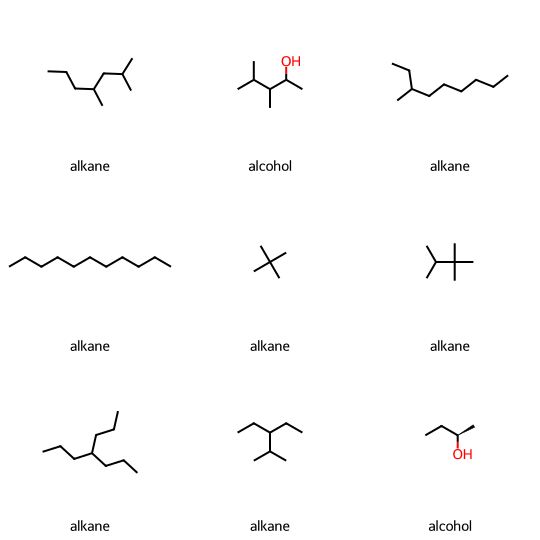

In [10]:
rng = np.random.default_rng(seed=42)
selected_ids_random = rng.choice(df.index.to_list(), 9, replace=False)

print(selected_ids_random)

graph_mols(mols, molsPerRow=3, subImgSize=(180, 180), selected_ids=selected_ids_random, output_file="selected_mols_random.png")

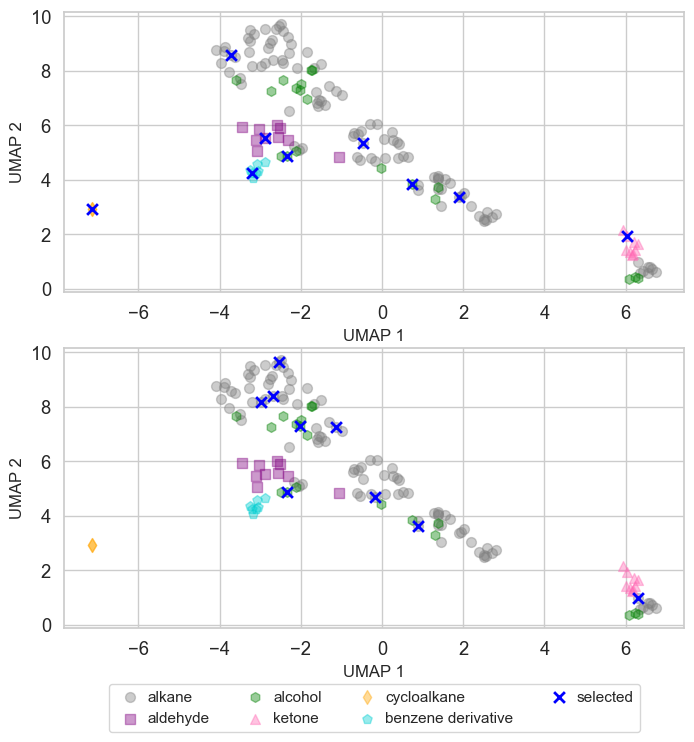

In [11]:
# plot two plots in one figure

# umap visualization of the molecules
from umap import UMAP

# umap = UMAP(
#     n_components=2,
#     random_state=42,
#     n_neighbors=18,
#     # min_dist=0.1,
#     # min_dist=0.2,
#     min_dist=0.12,
#     metric="jaccard",
# )
# X_umap = umap.fit_transform(ecfp)
# df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])

# plot the UMAP projections
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
# fig, axs = plt.subplots(2, 1, figsize=(7, 7))
# fig, axs = plt.subplots(2, 1, figsize=(6, 8))

ax = axs[0]
categories = df["Category"].unique()
colors_list = [
    "grey",
    "green",
    "hotpink",
    "purple",
    "orange",
    # "blue",
    # "cyan",
    # "orangered",
    "darkturquoise",
]
# markers_list = ["^", "x", "*", "_", "|", "2", "p", ">", "<", "v", "s"]
markers_list = ["o", "h", "^", "s", "d", "p"]
colors = dict(zip(categories, colors_list))
markers = dict(zip(categories, markers_list))

# df["Category"].unique()
for category in ['alkane', 'aldehyde', 'alcohol', 'ketone', 'cycloalkane', 'benzene derivative']:
    mask = df["Category"] == category
    # print(category)
    if category == "benzene derivative":
        ax.scatter(
            df_umap.loc[mask, "UMAP1"],
            df_umap.loc[mask, "UMAP2"],
            c=colors[category],
            # label="benzene\nderivative",
            label="benzene derivative",
            s=50,
            # marker line style
            edgecolors=None,
            alpha=0.4,
            # marker style
            marker=markers[category],
        )
    else:
        ax.scatter(
            df_umap.loc[mask, "UMAP1"],
            df_umap.loc[mask, "UMAP2"],
            c=colors[category],
            label=category,
            s=50,
            # marker line style
            edgecolors=None,
            alpha=0.4,
            marker=markers[category],
        )

# # plot the selected molecules with red color
ax.scatter(
    df_umap.loc[selected_ids8, "UMAP1"],
    df_umap.loc[selected_ids8, "UMAP2"],
    # c="black",
    c="blue",
    label="selected",
    s=60,
    marker="x",
    # marker line width
    linewidths=2,
)

# ax.legend(
#     loc="upper right",
#     # bbox_to_anchor=(0.5, -0.5),
#     ncol=1,
#     fontsize=11,
#     # frameon=False,
#     # columnspacing=0.5,
#     # labelspacing=0.5,
#     handletextpad=0.15,
# )

ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)

# # show legend outside the plot area, lower center
# plt.legend(
#     loc="lower center",
#     bbox_to_anchor=(0.5, -0.5),
#     ncol=2,
#     fontsize=12,
#     # frameon=False,
# )

ax = axs[1]
# df["Category"].unique()
for category in ['alkane', 'aldehyde', 'alcohol', 'ketone', 'cycloalkane', 'benzene derivative']:
    mask = df["Category"] == category
    # print(category)
    if category == "benzene derivative":
        ax.scatter(
            df_umap.loc[mask, "UMAP1"],
            df_umap.loc[mask, "UMAP2"],
            c=colors[category],
            # label="benzene\nderivative",
            label="benzene derivative",
            s=50,
            # marker line style
            edgecolors=None,
            alpha=0.4,
            # marker style
            marker=markers[category],
        )
    else:
        ax.scatter(
            df_umap.loc[mask, "UMAP1"],
            df_umap.loc[mask, "UMAP2"],
            c=colors[category],
            label=category,
            s=50,
            # marker line style
            edgecolors=None,
            alpha=0.4,
            marker=markers[category],
        )

# # plot the selected molecules with red color
ax.scatter(
    df_umap.loc[selected_ids_random, "UMAP1"],
    df_umap.loc[selected_ids_random, "UMAP2"],
    # c="black",
    c="blue",
    label="selected",
    s=60,
    marker="x",
    # marker line width
    linewidths=2,
)

ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)

# # set x ticks font size
# plt.xticks(fontsize=12)
# # set y ticks font size
# plt.yticks(fontsize=12)

# # only keep the one legend
# axs[0].legend().remove()
# move the legend to the bottom of the figure
axs[1].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    ncol=4,
    fontsize=11,
    # frameon=False,
    # columnspacing=0.5,
    # labelspacing=0.5,
    handletextpad=0.15,
)

# # save the figure
# plt.savefig("umap_projections.png", dpi=600, bbox_inches="tight")
# plt.savefig("umap_projections.pdf", dpi=600, bbox_inches="tight")

plt.show()